# Задание 4

#### Imports

In [8]:
import numpy as np
from skimage.feature import ORB, match_descriptors
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform, AffineTransform
from skimage.transform import warp
from skimage.filters import gaussian
from numpy.linalg import inv

import matplotlib.pyplot as plt
import cv2

In [10]:
def add_random_print_defects(im, n=5, max_width=0.01, mode='bw', white_p = 0.5):
    im_out = im.copy()
    colors = None
    if mode == 'bw':
        colors = 255 * np.random.binomial(1, white_p, n)
    elif mode == 'uniform':
        colors = 255 * np.random.uniform(0, 1, n)
    for color in colors:
        while True:
            start = np.random.uniform(0, im.shape[1])
            end = min(im.shape[1], start + np.random.uniform(0, im.shape[1] * max_width))
            start, end = int(start), int(end)
            if end == start:
                continue
            im_out[:, start:end] = color
            break
    return im_out

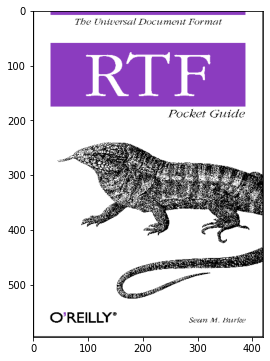

In [11]:
im = cv2.imread("scans/1.png")
im = cv2.resize(im, dsize=(420, 596))
plt.figure(figsize=(9, 6))
plt.imshow(im)

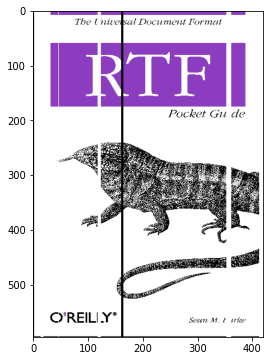

In [12]:
im_def = add_random_print_defects(im, n=7, max_width=0.02, mode='bw', white_p=0.9)
plt.figure(figsize=(9, 6))

plt.imshow(im_def)

In [13]:
x, y = np.mgrid[:4, :5]
x, y

(array([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3]]),
 array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]))

In [14]:
im[0, 0]

array([0, 0, 0], dtype=uint8)

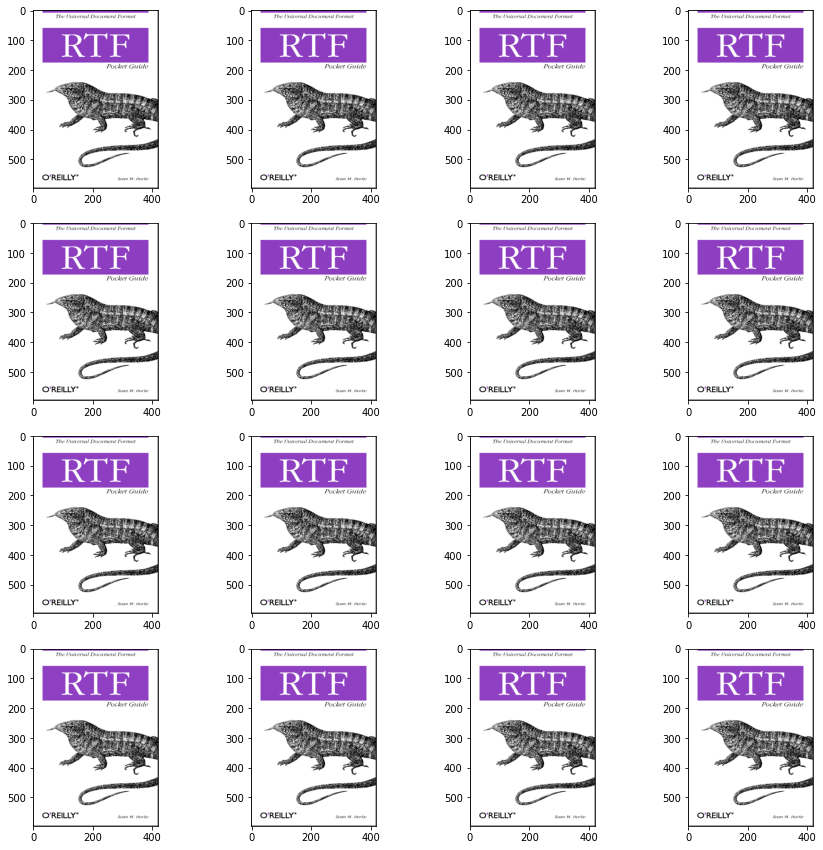

In [15]:
plt.figure(figsize=(15, 15))
for k, beta in enumerate(np.linspace(0.0, 4, 16)):
    plt.subplot(4, 4, k + 1)
    adjusted = cv2.convertScaleAbs(im, alpha=1, beta=beta)
    plt.imshow(adjusted)
plt.show()

In [16]:
def gauss_light(H, W, x0, y0, sigma=10000, gauss_scale=0.25):
    X, Y = np.mgrid[:H, :W]
    return np.exp(-((X - x0)**2 + (Y - y0)**2) / sigma) * gauss_scale

def add_uneven_lighting(im, n=3, sigma=10000, gauss_scale=0.25, smooth_kernel=5):
    im_out = im / 255
    H, W = im.shape[:2]
    for _ in range(n):
        x0, y0 = np.random.uniform(0, 1, 2) * np.array([H, W])
        im_out = np.clip(im_out + gauss_light(H, W, x0, y0, sigma, gauss_scale), 0, 1)
    im_out = cv2.GaussianBlur(im_out, (smooth_kernel, smooth_kernel), 0, 0)
    return (im_out * 255).astype(np.uint8)

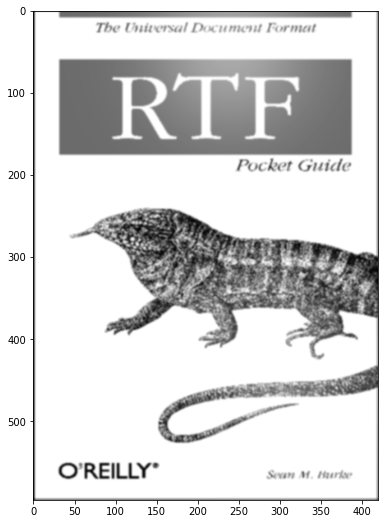

In [17]:
plt.figure(figsize=(15, 9))
curr = im
curr = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)
curr = add_uneven_lighting(curr, sigma=10000, gauss_scale=0.25, )
plt.imshow(curr, cmap='gray')
plt.show()

In [18]:
import numpy as np

def band_limited_noise(min_freq, max_freq, samples=44100, step=10):
    t = np.linspace(0, 1, samples)
    freqs = np.arange(min_freq, max_freq+1, step)
    phases = np.random.rand(len(freqs))*2*np.pi
    signals = np.array([np.sin(2*np.pi*freq*t + phase) for freq, phase in zip(freqs,phases)])
    signal = signals.sum(axis=0)
    signal /= np.max(signal)
    return signal

In [19]:
im

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [ 14,  14,  14],
        [205, 205, 205],
        ...,
        [205, 205, 205],
        [205, 205, 205],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [ 17,  17,  17],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [ 17,  17,  17],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [ 14,  14,  14],
        [205, 205, 205],
        ...,
        [205, 205, 205],
        [205, 205, 205],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [20]:
im.shape

(596, 420, 3)

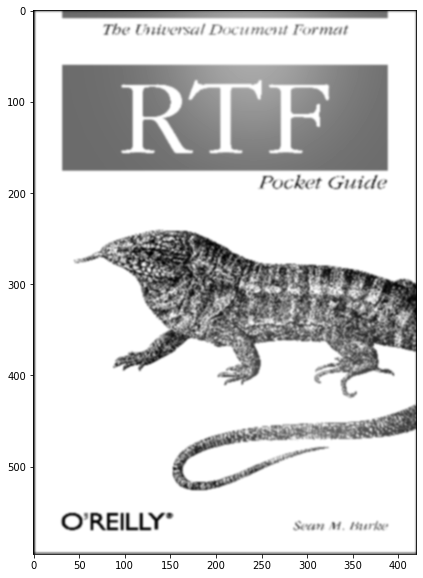

In [21]:
def band_limited_noise(min_freq, max_freq, samples=44100, step=10):
    t = np.linspace(0, 1, samples)
    freqs = np.arange(min_freq, max_freq+1, step)
    phases = np.random.rand(len(freqs))*2*np.pi
    signals = np.array([np.sin(2*np.pi*freq*t + phase) for freq, phase in zip(freqs,phases)])
    signal = signals.sum(axis=0)
    signal /= np.max(signal)
    return signal


def add_hf_noise(im, coef=0.05):
    im_out = im / 255 if im.dtype == np.uint8 else im

    noise_x = band_limited_noise(500, 2500, im.shape[1], 1)
    noise_y = band_limited_noise(500, 2500, im.shape[0], 1)

    noise = noise_y.reshape(-1, 1) * noise_x.reshape(1, -1)
    noise = (noise + 1) / 2

    if len(im.shape) == 3:
        noise = noise.reshape(im.shape[0], im.shape[1], 1)
    
    return im * (1 - coef) + noise * coef

plt.figure(figsize=(10, 10))
plt.imshow(add_hf_noise(curr, coef=0.05), cmap='gray')
plt.show()

In [22]:
def get_bayer_masks(n_rows, n_cols):
    result = np.zeros((n_rows, n_cols, 3))

    cols, rows = np.meshgrid(np.arange(n_cols), np.arange(n_rows))

    result[:, :, 0] = np.where((cols % 2 == 0) & (rows % 2 == 0), 1, 0)  # Red
    result[:, :, 1] = np.where((cols + rows + 1) % 2 == 0, 1, 0)         # Green
    result[:, :, 2] = np.where((cols % 2 == 1) & (rows % 2 == 1), 1, 0)  # Blue
    return result.astype(bool)


def get_colored_img(raw_img):
    return np.where(get_bayer_masks(*raw_img.shape), raw_img[..., np.newaxis], 0)


def mosaicing(img):
    return (img * get_bayer_masks(*img.shape[:2])).sum(axis=-1).astype(np.uint8)


def get_shift(img, shift_x, shift_y):
    result = np.zeros(img.shape, dtype=np.float32)
    from_x1, from_x2 = max(0, shift_x), img.shape[0] + min(0, shift_x)
    from_y1, from_y2 = max(0, shift_y), img.shape[1] + min(0, shift_y)

    to_x1, to_x2 = max(0, -shift_x), img.shape[0] + min(0, -shift_x)
    to_y1, to_y2 = max(0, -shift_y), img.shape[1] + min(0, -shift_y)
    result[to_x1:to_x2, to_y1:to_y2] += img[from_x1:from_x2, from_y1:from_y2]
    return result


def shift_conv(img, shifts_x=None, shifts_y=None, weights=None, normed=True):
    result = np.zeros(img.shape, dtype=np.float32)
    if shifts_x is None or shifts_y is None:
        shifts_x = np.array([ 1, 1, 1, 0, 0,  0, -1, -1, -1])
        shifts_y = np.array([-1, 0, 1, 1, 0, -1, -1,  0,  1])
    else:
        shifts_x = np.array(shifts_x)
        shifts_y = np.array(shifts_y)
    weights = np.ones_like(shifts_x) if weights is None else np.array(weights)

    for shift_x, shift_y, weight in zip(shifts_x, shifts_y, weights):
        result += get_shift(img, shift_x, shift_y) * weight

    if normed:
        result /= weights.sum()
    return result


def bilinear_interpolation(colored_img):
    bayer_mask = get_bayer_masks(*colored_img.shape[:-1])
    img_conv = shift_conv(colored_img)
    mask_conv = shift_conv(bayer_mask)
    inter = (img_conv / mask_conv).astype(dtype=np.uint8)

    # для известных значений ничего не интерполируем
    return colored_img + inter * (1 - bayer_mask)


def demosaicing_damage(img):
    return bilinear_interpolation(get_colored_img(mosaicing(img)))

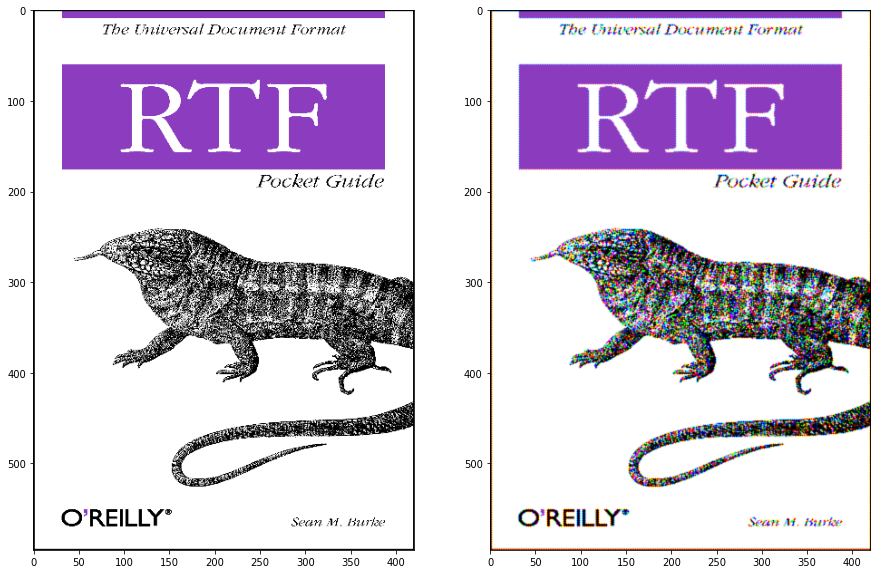

In [23]:
plt.figure(figsize=(15, 20))
curr = bilinear_interpolation(get_colored_img(mosaicing(im)))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(curr)
plt.show()

In [24]:
k = 10
print(f"{k:03d}")

010


In [29]:
def to_grayscale(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


def add_random_print_defects(im, n=5, max_width=0.01, mode='bw', white_p = 0.5):
    im_out = im.copy()
    colors = None
    if mode == 'bw':
        colors = 255 * np.random.binomial(1, white_p, n)
    elif mode == 'uniform':
        colors = 255 * np.random.uniform(0, 1, n)
    for color in colors:
        while True:
            start = np.random.uniform(0, im.shape[1])
            end = min(im.shape[1], start + np.random.uniform(0, im.shape[1] * max_width))
            start, end = int(start), int(end)
            if end == start:
                continue
            im_out[:, start:end] = color
            break
    return im_out


def add_low_contrast(im, alpha=0.75):
    return cv2.convertScaleAbs(im, alpha=alpha, beta=1)


def gauss_light(H, W, x0, y0, sigma=10000, gauss_scale=0.25):
    X, Y = np.mgrid[:H, :W]
    return np.exp(-((X - x0)**2 + (Y - y0)**2) / sigma) * gauss_scale


def add_uneven_lighting(im, n=3, sigma=10000, gauss_scale=0.25, smooth_kernel=5):
    im_out = im / 255
    H, W = im.shape[:2]
    for _ in range(n):
        x0, y0 = np.random.uniform(0, 1, 2) * np.array([H, W])
        im_out = np.clip(im_out + gauss_light(H, W, x0, y0, sigma, gauss_scale), 0, 1)
    im_out = cv2.GaussianBlur(im_out, (smooth_kernel, smooth_kernel), 0, 0)
    return (im_out * 255).astype(np.uint8)


def band_limited_noise(min_freq, max_freq, samples=44100, step=10):
    t = np.linspace(0, 1, samples)
    freqs = np.arange(min_freq, max_freq+1, step)
    phases = np.random.rand(len(freqs))*2*np.pi
    signals = np.array([np.sin(2*np.pi*freq*t + phase) for freq, phase in zip(freqs,phases)])
    signal = signals.sum(axis=0)
    signal /= np.max(signal)
    return signal


def add_hf_noise(im, coef=0.05):
    im_out = im / 255 if im.dtype == np.uint8 else im

    noise_x = band_limited_noise(500, 2500, im.shape[1], 1)
    noise_y = band_limited_noise(500, 2500, im.shape[0], 1)

    noise = noise_y.reshape(-1, 1) * noise_x.reshape(1, -1)
    noise = (noise + 1) / 2

    if len(im.shape) == 3:
        noise = noise.reshape(im.shape[0], im.shape[1], 1)
    
    return im * (1 - coef) + noise * coef


def get_bayer_masks(n_rows, n_cols):
    result = np.zeros((n_rows, n_cols, 3))

    cols, rows = np.meshgrid(np.arange(n_cols), np.arange(n_rows))

    result[:, :, 0] = np.where((cols % 2 == 0) & (rows % 2 == 0), 1, 0)  # Red
    result[:, :, 1] = np.where((cols + rows + 1) % 2 == 0, 1, 0)         # Green
    result[:, :, 2] = np.where((cols % 2 == 1) & (rows % 2 == 1), 1, 0)  # Blue
    return result.astype(bool)


def get_colored_img(raw_img):
    return np.where(get_bayer_masks(*raw_img.shape), raw_img[..., np.newaxis], 0)


def mosaicing(img):
    return (img * get_bayer_masks(*img.shape[:2])).sum(axis=-1).astype(np.uint8)


def get_shift(img, shift_x, shift_y):
    result = np.zeros(img.shape, dtype=np.float32)
    from_x1, from_x2 = max(0, shift_x), img.shape[0] + min(0, shift_x)
    from_y1, from_y2 = max(0, shift_y), img.shape[1] + min(0, shift_y)

    to_x1, to_x2 = max(0, -shift_x), img.shape[0] + min(0, -shift_x)
    to_y1, to_y2 = max(0, -shift_y), img.shape[1] + min(0, -shift_y)
    result[to_x1:to_x2, to_y1:to_y2] += img[from_x1:from_x2, from_y1:from_y2]
    return result


def shift_conv(img, shifts_x=None, shifts_y=None, weights=None, normed=True):
    result = np.zeros(img.shape, dtype=np.float32)
    if shifts_x is None or shifts_y is None:
        shifts_x = np.array([ 1, 1, 1, 0, 0,  0, -1, -1, -1])
        shifts_y = np.array([-1, 0, 1, 1, 0, -1, -1,  0,  1])
    else:
        shifts_x = np.array(shifts_x)
        shifts_y = np.array(shifts_y)
    weights = np.ones_like(shifts_x) if weights is None else np.array(weights)

    for shift_x, shift_y, weight in zip(shifts_x, shifts_y, weights):
        result += get_shift(img, shift_x, shift_y) * weight

    if normed:
        result /= weights.sum()
    return result


def bilinear_interpolation(colored_img):
    bayer_mask = get_bayer_masks(*colored_img.shape[:-1])
    img_conv = shift_conv(colored_img)
    mask_conv = shift_conv(bayer_mask)
    inter = (img_conv / mask_conv).astype(dtype=np.uint8)

    # для известных значений ничего не интерполируем
    return colored_img + inter * (1 - bayer_mask)


def demosaicing_damage(img):
    return bilinear_interpolation(get_colored_img(mosaicing(img)))


def bilateral_denoising(im, k=7):
    return cv2.bilateralFilter(im, k, 75, 75)

In [44]:
a = np.zeros((2, 2)).tolist()
type(a[0][0])

float

In [41]:
import os
os.listdir("tables")

['table_3.jpg',
 'table_7.jpg',
 'table_10.jpg',
 'table_8.jpg',
 'table_5.jpg',
 'table_4.jpg',
 'table_11.jpg',
 'table_6.jpg',
 'table_9.jpg',
 'table_2.jpg',
 'table_1.jpg']

In [39]:
diff = ((im - curr -0.5 + 0.5)**2).mean()
diff

6274.019883881964

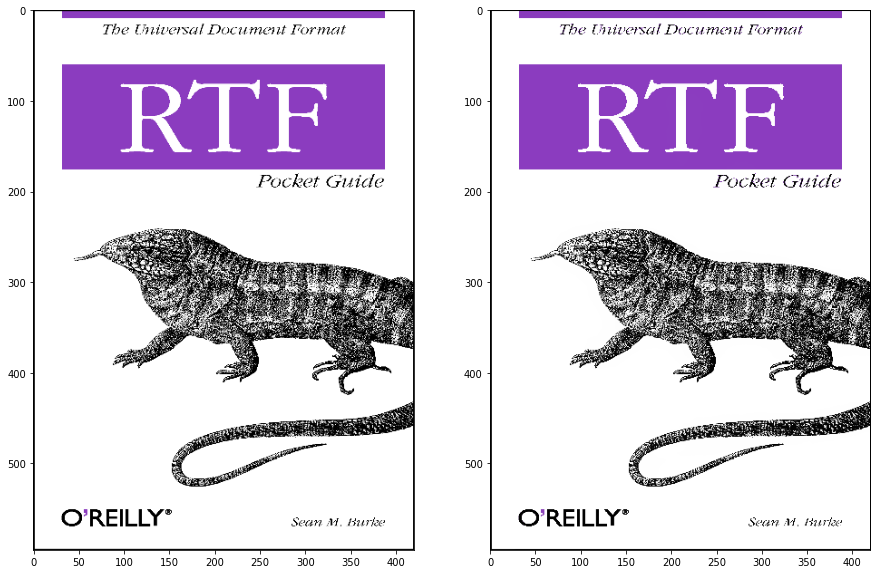

In [37]:
plt.figure(figsize=(15, 20))
curr = bilateral_denoising(im, k=55)
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(curr)
plt.show()

In [60]:
paper = cv2.imread("paper/paper_2.jpg")
paper = cv2.resize(paper, im.shape[1::-1])
paper.shape

(596, 420, 3)

array([[[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [False],
        [False],
        ...,
        [False],
        [False],
        [ True]],

       [[ True],
        [False],
        [False],
        ...,
        [False],
        [False],
        [ True]],

       ...,

       [[ True],
        [False],
        [False],
        ...,
        [False],
        [False],
        [ True]],

       [[ True],
        [False],
        [False],
        ...,
        [False],
        [False],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]]])

In [70]:
def add_paper(im, paper):
    if len(im.shape) != 3:
        im = im.copy().reshape(*im.shape, 1)
        
    if len(paper.shape) != 3:
        paper = paper.copy().reshape(*paper.shape, 1)

    return np.where(
        ((im == 255).min(axis=-1)).reshape(*im.shape[:2], 1),
        paper,
        im,
    ).squeeze()

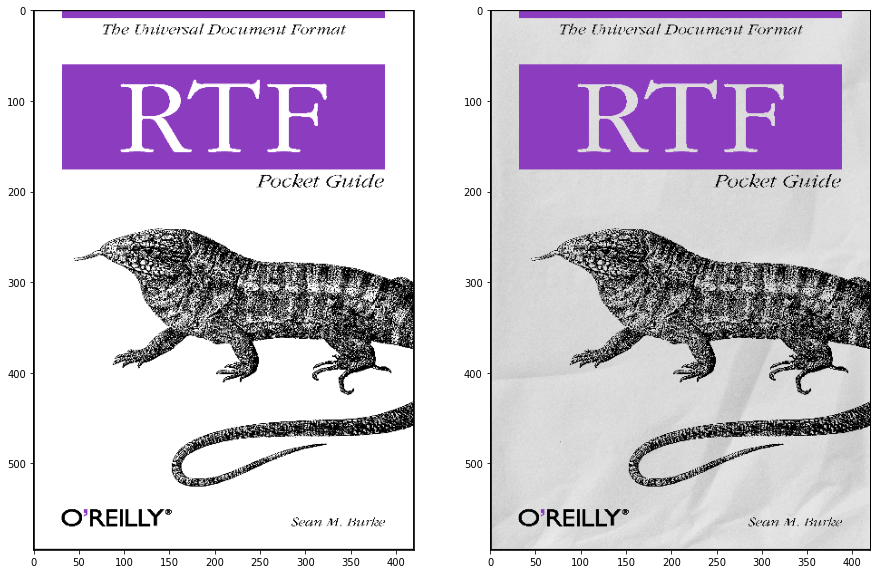

In [71]:
curr = add_paper(im, paper)
plt.figure(figsize=(15, 20))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(curr)
plt.show()

In [45]:
im

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [ 14,  14,  14],
        [205, 205, 205],
        ...,
        [205, 205, 205],
        [205, 205, 205],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [ 17,  17,  17],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [ 17,  17,  17],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [ 14,  14,  14],
        [205, 205, 205],
        ...,
        [205, 205, 205],
        [205, 205, 205],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
cv2.bilateralFilter(im,9,75,75)

In [3]:
at = AffineTransform(rotation=np.pi/4)
at.params

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [2]:

# M = cv2.getPerspectiveTransform(pts_src, pts_dst)
# im_out = cv2.warpPerspective(im_src, M, (im_src.shape[1], im_src.shape[0]))


def mouse_handler(event, x, y, flags, data):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(data['im'], (x, y), 25, (0, 0, 255), -1)
        cv2.imshow("Image", data['im'])
        if len(data['points']) < 4:
            data['points'].append([x, y])
 
 
def get_four_points(im):
    data = {}
    data['im'] = im.copy()
    data['points'] = []
 
    cv2.imshow("Image", im)
    cv2.setMouseCallback("Image", mouse_handler, data)
    cv2.waitKey(0)
 
    points = np.float32(data['points'])
    return points
 

# Read in the image.
im_src = cv2.imread("tables/orig (1).jpg")

# Show image and wait for 4 clicks.
pts_src = get_four_points(im_src)

# Book size
size = im_src.shape[:2]

print(pts_src)
print(size)
# Destination coordinates located in the center of the image
# pts_dst = np.float32(
#     [
#         [im_src.shape[1]/2 - size[0]/2, im_src.shape[0]/2 - size[1]/2],
#         [im_src.shape[1]/2 + size[0]/2, im_src.shape[0]/2 - size[1]/2],
#         [im_src.shape[1]/2 + size[0]/2, im_src.shape[0]/2 + size[1]/2],
#         [im_src.shape[1]/2 - size[0]/2, im_src.shape[0]/2 + size[1]/2]
#         ]
# )

# # Calculate the homography
# M = cv2.getPerspectiveTransform(pts_src, pts_dst)

# # Warp source image to destination
# im_out = cv2.warpPerspective(im_src, M, (im_src.shape[1], im_src.shape[0])

# # Show output
# cv2.imshow("Warped Source Image", im_out)
# cv2.imwrite("book_bird_eye_view.jpg", im_out)

# cv2.waitKey(0)

ImportError: DLL load failed while importing cv2: Не найдена указанная процедура.

#### Поиск матрицы гомографии

In [2]:
def center_and_normalize_points(points):
    """Center the image points, such that the new coordinate system has its
    origin at the centroid of the image points.

    Normalize the image points, such that the mean distance from the points
    to the origin of the coordinate system is sqrt(2).

    points ((N, 2) np.ndarray) : the coordinates of the image points

    Returns:
        (3, 3) np.ndarray : the transformation matrix to obtain the new points
        (N, 2) np.ndarray : the transformed image points
    """

    C = points.mean(axis=0)
    new_points = points - C
    N = np.sqrt(2) / np.linalg.norm(new_points, axis=1).mean()
    new_points = N * new_points
    M = np.array([
        [N, 0, -N * C[0]],
        [0, N, -N * C[1]],
        [0, 0,         1],
    ])

    return M, new_points


def find_homography(src_keypoints, dest_keypoints):
    """Estimate homography matrix from two sets of N (4+) corresponding points.

    src_keypoints ((N, 2) np.ndarray) : source coordinates
    dest_keypoints ((N, 2) np.ndarray) : destination coordinates

    Returns:
        ((3, 3) np.ndarray) : homography matrix
    """
    assert src_keypoints.shape == dest_keypoints.shape

    src_matrix, src_normalized = center_and_normalize_points(src_keypoints)
    dest_matrix, dest_normalized = center_and_normalize_points(dest_keypoints)

    # x_1 and y_1
    x1 = src_normalized[:, 0]
    y1 = src_normalized[:, 1]

    # x_2' and y_2'
    x2 = dest_normalized[:, 0]
    y2 = dest_normalized[:, 1]

    N = src_keypoints.shape[0]
    A = np.zeros(shape=(2 * N, 9))

    # a_x
    A[::2, 0] = -x1
    A[::2, 1] = -y1
    A[::2, 2] = -1
    A[::2, 3:6] = 0
    A[::2, 6:9] = -x2[:, np.newaxis] * A[::2, 0:3]

    # a_y
    A[1::2, 0:3] = 0
    A[1::2, 3] = -x1
    A[1::2, 4] = -y1
    A[1::2, 5] = -1
    A[1::2, 6:9] = -y2[:, np.newaxis] * A[1::2, 3:6]

    H = np.linalg.svd(A)[2][-1].reshape(3, 3)

    return inv(dest_matrix) @ H @ src_matrix

#### Преобразование изображения

In [3]:
def rotate_transform_matrix(transform):
    """Rotate matrix so it can be applied to row:col coordinates."""
    matrix = transform.params[(1, 0, 2), :][:, (1, 0, 2)]
    return type(transform)(matrix)


def warp_image(image, transform, output_shape):
    """Apply transformation to an image and its mask

    image ((W, H, 3)  np.ndarray) : image for transformation
    transform (skimage.transform.ProjectiveTransform): transformation to apply
    output_shape (int, int) : shape of the final pano

    Returns:
        (W, H, 3)  np.ndarray : warped image
        (W, H)  np.ndarray : warped mask
    """
    mask = np.ones(shape=image.shape[:2], dtype=np.bool8)
    transform = rotate_transform_matrix(transform)

    return warp(image, transform, output_shape=output_shape), warp(mask, transform, output_shape=output_shape)

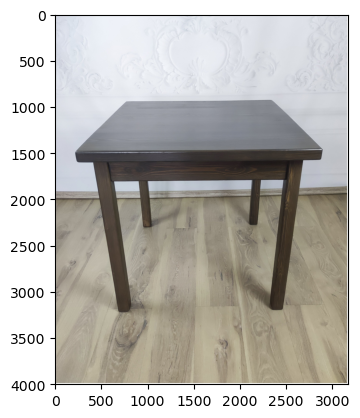

In [6]:
table_img = plt.imread("tables/orig (2).jpg")
plt.imshow(table_img)
plt.scatter()

In [ ]:
table_points_0 = np.array([
    [0, 0],
    [0, 120],
    [120, 0],
    [120, 120],
])

table_points_1 = np.array([
    [0, 0],
    [0, 120],
    [120, 0],
    [120, 120],
])